In [34]:
pip install qiskit pylatexenc

Note: you may need to restart the kernel to use updated packages.


In [53]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, AncillaRegister, Parameter
from qiskit.circuit.library import UnitaryGate

from qiskit.quantum_info import Statevector, Operator
import pylatexenc

import matplotlib.pyplot as plt

import numpy as np

# Mini-project 2

**Author: Lara Ismert**

**Date: June 16, 2025**

In this project, we will implement the oracle $U_a$ which is implemented in the order-finding part of Shor's algorithm.

Fix $a,N\in \mathbb{Z}_+$ such that $a< N$, and set $n:=2 \lceil \log_2(N) \rceil.$  Write a Qiskit function which outputs the oracle $U_a$ such that for all $\ket{y}_n$:
$$
    U_a\ket{x}_1\ket{y}_n
    =
    \begin{cases}
    \ket{x}_1 \ket{ay \mod N}_n \quad \text{if }x=1 \\
    \ket{x}_1\ket{y}_n \quad \text{otherwise}
    \end{cases}
$$

The construction may only use 1-qubit gates, multi-controlled phase and X gates with any number of controls, and the built-in version of the Quantum Fourier Transform (and its inverse). No classical bit and measurements allowed.

This oracle is the only "quantum" part of Shor's algorithm to find a factor of $N$. In particular, Shor's original paper gives a reduction of the factoring problem to the **order-finding problem**, wherein we seek to find $r\in \mathbb{N}$ such that $a^r \equiv 1\mod N$, assuming $gcd(a,N)=1$ (otherwise, the Euclidean algorithm for computing $gcd(a,N)$ will provide a nontrivial factor of $N$).

Notice that the order $r$ of the group element $a\mod N$ also satisfies $U_a^r\ket{x}_1\ket{1}_n = \ket{x}_1\ket{1}_n$ for all $x\in \mathbb{F}_2$. Finding $r$ can be done using the following circuit:

In [158]:
# Input the standard matrix rep of your desired single-qubit unitary

matrix_U = [[0, 1], [-1, 0]] 

# Make U into a gate by applying UnitaryGate to the matrix U

U_gate = UnitaryGate(matrix_U)



Below is a controlled $U_a$ gate.

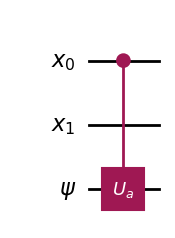

In [130]:
n = 2

qr = QuantumRegister(size=n, name="x")
ar = AncillaRegister(size=1,name = r"\psi")

U_circuit = QuantumCircuit(ar,name = "$U_a$")
U_circuit.append(U_gate,ar)

controlled_U_gate = U_circuit.to_gate().control(1)
 
controlled_U_circuit = QuantumCircuit(qr,ar)
controlled_U_circuit.append(controlled_U_gate, [0, -1])
controlled_U_circuit.draw('mpl')

Now I want to be able to change the exponent of $a$ to $2^k$ for some $k\in [n]$, and also move the control qubit to be $k$.

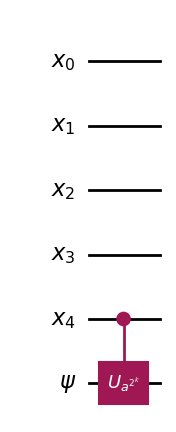

In [159]:
# Singly-controlled powers of U

n = 5
k=4

U_k_gate = UnitaryGate(np.linalg.matrix_power(U, 2**k))

qr = QuantumRegister(size=n, name="x")
ar = AncillaRegister(size=1,name = r"\psi")

U_2k_circuit = QuantumCircuit(ar,name = "$U_{a^{2^k}}$")
U_2k_circuit.append(U_k_gate,ar)

controlled_U_2k_gate = U_2k_circuit.to_gate().control(1)
 
controlled_U_2k_circuit = QuantumCircuit(qr,ar)
controlled_U_2k_circuit.append(controlled_U_2k_gate, [k, -1])

controlled_U_2k_circuit.draw('mpl')

The full order-finding circuit includes an application of the inverse quantum Fourier transform on the non-ancilla qubits.

In [288]:
# Here we have borrowed code from the QC Bootcamp 2 Problem Session
def quantum_fourier_transform(n):
    quantum_register = QuantumRegister(size=n, name="x")
    QFT_circuit = QuantumCircuit(quantum_register, name="QFT")

    for q, p in zip(quantum_register[:n >> 1], reversed(quantum_register[n >> 1:])):
        QFT_circuit.swap(q, p)

    for i, q in enumerate(quantum_register, start=1):
        QFT_circuit.h(q)
        for j, p in enumerate(quantum_register[i:], start=1):
            QFT_circuit.cp(np.pi / (1 << j), q, p)

    return QFT_circuit

def inverse_quantum_fourier_transform(n):
    quantum_register = QuantumRegister(size=n, name="x")
    inverse_QFT_circuit = QuantumCircuit(quantum_register, name=f"IQFT")

    for i, q in enumerate(reversed(quantum_register), start=1):
        for j, p in enumerate(reversed(quantum_register[n + 1 - i:]), start=1):
            inverse_QFT_circuit.cp(- np.pi / (1 << (i - j)), q, p)
        inverse_QFT_circuit.h(q)

    for q, p in zip(quantum_register[:n >> 1], reversed(quantum_register[n >> 1:])):
        inverse_QFT_circuit.swap(q, p)

    return inverse_QFT_circuit.to_gate()

The full quantum phase estimation in Shor's algorithm looks like this:

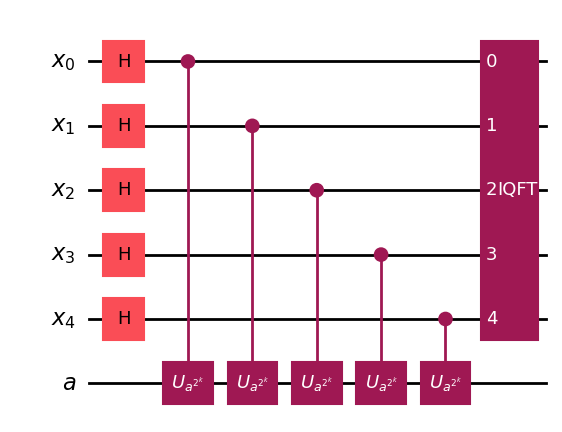

In [289]:
n = 5

qr = QuantumRegister(size=n, name="x")
ar = AncillaRegister(size=1,name = "a")

U_2k_circuit = QuantumCircuit(ar,name = "$U_{a^{2^k}}$")
U_2k_circuit.append(U_k_gate,ar)

controlled_U_2k_gate = U_2k_circuit.to_gate().control(1)

QPE_circuit_U = QuantumCircuit(qr,ar,name = f"QPE")

#Prep states
QPE_circuit_U.h(qr)

for k,q in enumerate(qr):
    QPE_circuit_U.append(controlled_U_2k_gate, [k, -1])

QPE_circuit_U.append(inverse_quantum_fourier_transform(n),qr)

QPE_circuit_U.draw('mpl')

# Implementing the oracle $U_a$

Our main source for implementing this oracle comes from St\'ephane Beauregard's 2003 article **Circuit for Shor’s algorithm using $2n+3$ qubits**. Note that the number of qubits needed to implement Beauregard's circuit, $2n+3$, does not depend on the size of the integer $N$, to be factored. Similarly, the circuit requires $\mathcal{O}(n^3 \log(n))$ elementary quantum gates with a depth of $\mathcal{O}(n^3)$.

We will implement $U_a\ket{x}_1\ket{y}_n = \ket{x}_1\ket{ay \mod N}_n$ following Beauregard's deconstruction of $U_a$ into three main steps.
1. The $\phi ADD(a)$ gate, which is a Draper adder applied to the images of qubits under the QFT. 

2. Once we have the $\phi ADD(a)$ gate, we can build the $\phi ADD(a) \mod N$, which determines when the image $\phi ADD(a)\ket{\phi(b)}_n = \ket{\phi(a+b)}_N$ needs to subtract $N$ in order to be within $\{0,\dots, N-1\}$. This circuit requires:

- *three* doubly-controlled $\phi ADD(a)$ gates or their inverses ($\phi SUBTRACT(a)$)

- *two* applications of both $QFT^\dagger$ and $QFT$, 

- *one* controlled-$\phi ADD(N)$ gate and two controlled-NOT gates, and

- *two* NOT gates.

3. Nearly there, we build $MULT(a)MOD(N)$, which includes 
- $k$ iterations of singly-controlled $\phi ADD(2^k a)MOD(N)$ gates, and 

- both the $QFT$ and $QFT^\dagger$.

4. Last, we construct $C-MULT(a)MOD(N)$ to the original register with one additional qubit to serve as the control.


## Step 1: $\phi ADD(a)$

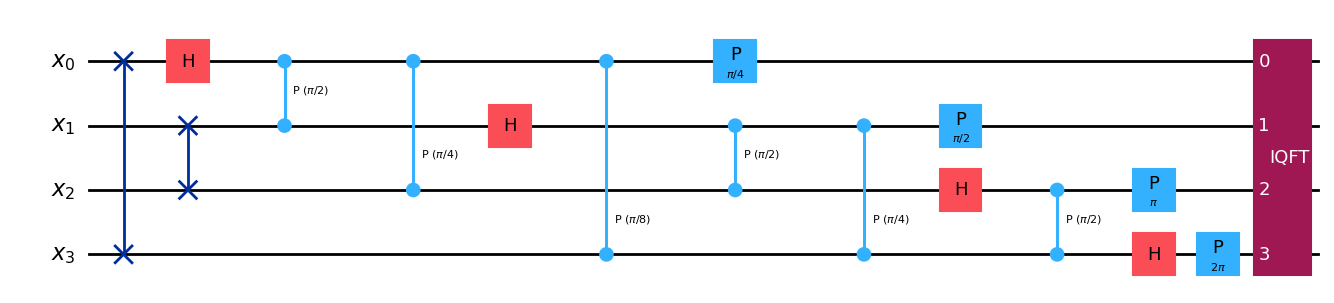

In [396]:
# This code was borrowed from the QC Bootcamp 2 Problem Session

def quantum_adder(a, n):
    quantum_register = QuantumRegister(size=n, name="x")
    quantum_adder_circuit = QuantumCircuit(quantum_register, name=f"{k} adder")
    
    quantum_adder_circuit.compose(quantum_fourier_transform(n), inplace=True)

    #quantum_adder_circuit.barrier()
    
    # phaser part
    for idx, q in enumerate(reversed(quantum_register)):
        quantum_adder_circuit.p(np.pi * a / (1 << idx), q)
    
    #quantum_adder_circuit.barrier()
    
    quantum_adder_circuit.compose(inverse_quantum_fourier_transform(n), inplace=True)
    
    return quantum_adder_circuit

quantum_adder(2,4).draw('mpl')


In [291]:
# If N is the composite number we wish to factor,
# Shor's algorithm computes the order mod N of a 
# random number $a$ chosen between 2 and N-1

import random

N = 10
n = len(bin(N)) - 2 # We need the same number of qubits as the length of N in binary
a = random.randint(2,N-1)
print([bin(N),a,n])

['0b1010', 4, 4]


Here is the $\phi ADD(a)$ circuit for the above $N$ and randomly chosen $a\in \{2,\dots, N-1\}$.

In [ ]:

def phiAdd(a,n):
    qr = QuantumRegister(n,'b')
    phi_Add_A_circuit = QuantumCircuit(qr, name=r'$\phi ADD(a)$')

    phi_Add_A_circuit.append(quantum_fourier_transform(n), qr)
    phi_Add_A_circuit.append(quantum_adder(a,n), qr)

    return phi_Add_A_circuit

def phiSubtract(a,n):
    qr = QuantumRegister(n,'b')
    phi_Minus_A_circuit = QuantumCircuit(qr,name = r'$\phi ADD(a)^\dagger$')
    phi_Minus_A_circuit.append(phiAdd(a,n).inverse(),qr)
    
    return phi_Minus_A_circuit

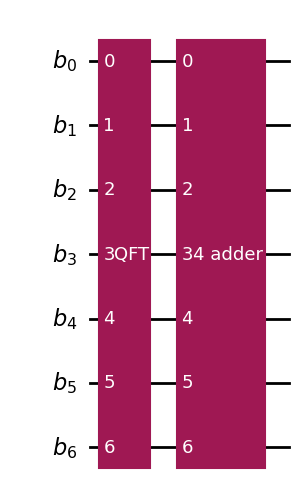

In [293]:

phiAdd(3,7).draw("mpl")

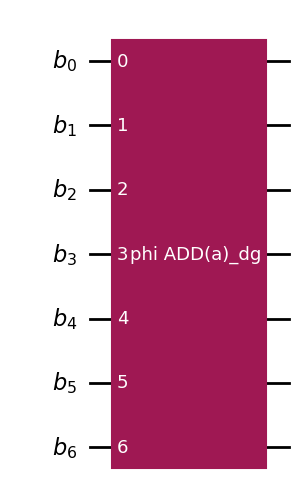

In [285]:
phiSubtract(3,7).draw("mpl")

## Step 2: $\phi ADD(a)\mod N$

We begin by creating two functions which will produce doubly-controlled $\phi ADD(a)$ and $\phi ADD(a)^\dagger$ gates.

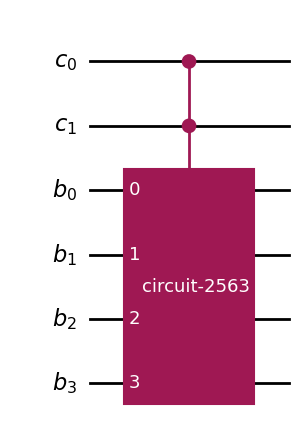

In [402]:
def CCphiAdd(a,n):
    cr = AncillaRegister(2,'c')
    qr = QuantumRegister(n, 'b')
    CC_phiAdd_circuit = QuantumCircuit(cr,qr, name = 'CCphiADD')

    # Base circuit 
    qc = QuantumCircuit(qr)
    #qc.ccx(n,0,1)
    qc.compose(quantum_adder(a,n),inplace = True)

    # Doubly controlled base circuit
    cc_quantum_adder = qc.to_gate().control(2)
    tbits = list(range(2,n+2))
    cbits = list(range(2))
    CC_phiAdd_circuit.append(cc_quantum_adder, cbits + tbits)

    #return qc
    return CC_phiAdd_circuit

def CCphiSubtract(a,n):
    cr = AncillaRegister(2,'c')
    qr = QuantumRegister(n, 'b')
    CC_phiMinus_circuit = QuantumCircuit(cr,qr, name = 'CCphiMINUS')

    # Base circuit 
    qc = QuantumCircuit(qr)
    #qc.ccx(n,0,1)
    qc.compose(quantum_adder(a,n).inverse(),inplace = True)

    # Doubly controlled base circuit
    cc_quantum_adder_inverse = qc.to_gate().control(2)
    tbits = list(range(2,n+2))
    cbits = list(range(2))
    CC_phiMinus_circuit.append(cc_quantum_adder_inverse,cbits + tbits)
    
    return CC_phiMinus_circuit

CCphiSubtract(2,4).draw('mpl')

In [231]:
N = 10
n = len(bin(N)) - 2 # We need the same number of qubits as the length of N in binary
a = random.randint(2,N-1)

cr = AncillaRegister(2,'c')
qr = QuantumRegister(n, 'b')
ar = AncillaRegister(1, '0')

Add_a_mod_N_circuit = QuantumCircuit(cr,qr,ar,name = r'$\phi ADD(a) mod N$')






QiskitError: 'One or more instructions cannot be converted to a gate. "$\\phi ADD(a)$" is not a gate instruction'